In [1]:
import torch
from math import sqrt

num_pats = 100
sq = 1;                         # Size of square
r = sq/sqrt(2*torch.pi);              # Radius of circle so it's half area of square
xcent = 0.5
ycent = 0.5                    # Centre of circle
xs = xcent*torch.ones((1,num_pats))
ys = ycent*torch.ones((1,num_pats))
train_rng = torch.random.manual_seed(12345) #torch.random.Generator(torch.random.PCG64(12345))
rng = torch.random.manual_seed(84562) #torch.random.Generator(torch.random.PCG64())
a = torch.concatenate((xs,ys)) + 0.5-torch.rand((2, num_pats))
bmat = ((a[0,:]-xcent)**2 + (a[1,:]-ycent)**2) > r**2
bmat = torch.vstack((bmat.long(), 1-bmat.long()))

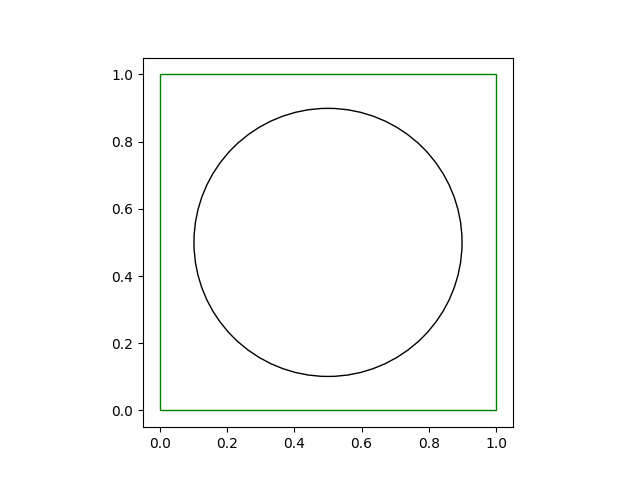

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches

figure, axes = plt.subplots()
draw_circle = plt.Circle((xcent, ycent), r, fill=False)
input_area = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="g", facecolor='none')

plotted_x = []
plotted_y = []
draw_points = axes.scatter(plotted_x, plotted_y)

axes.set_aspect(1)
axes.add_patch(draw_circle)
axes.add_patch(input_area)
axes.add_artist(draw_points)


In [3]:
def reset_plot():
    global figure, axes, draw_circle, input_area, plotted_x, plotted_y, draw_points
    figure, axes = plt.subplots()
    draw_circle = plt.Circle((xcent, ycent), r, fill=False)
    input_area = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="g", facecolor='none')
    plotted_x = []
    plotted_y = []
    draw_points = axes.scatter(plotted_x, plotted_y)

    axes.set_aspect(1)
    axes.add_patch(draw_circle)
    axes.add_patch(input_area)
    axes.add_artist(draw_points)

    plt.title('Circle')

In [4]:
rects = {}
def update_rect(index, bottom_left, height, width, in_class):
    edge_color = "b"
    if in_class:
        edge_color = "r"
    if height < 0.0001 and width < 0.0001:
        height = 0.01
        width = 0.01
    rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor=edge_color, facecolor='none')
    if index in rects:
        rects[index].remove()
    rects[index] = rect
    axes.add_artist(rect)


In [5]:
import numpy as np
def add_point(x,y):
    plotted_x.append(x)
    plotted_y.append(y)
    draw_points.set_offsets(np.c_[plotted_x, plotted_y])

tensor(9)
torch.Size([51, 4])
torch.Size([51, 2])
torch.Size([51])


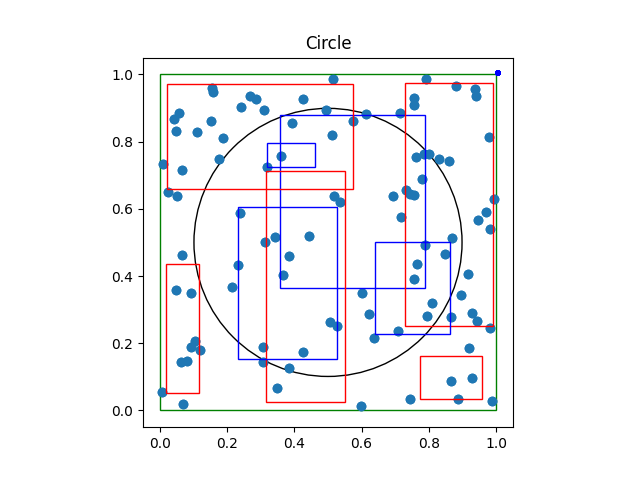

In [6]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

# circle in box

# 0 1 == _in_
# 1 0 == _out_
from fuzzy_artmap import FuzzyArtMap
reset_plot()
fuzzy_artmap = FuzzyArtMap(4, 1, baseline_vigilance = 0.0)

for i in range(num_pats):
    test_input = torch.transpose(a[:, i, None], 0, 1)
    ground_truth = torch.transpose(bmat[:, i, None], 0, 1)
    complement_encoded_input = FuzzyArtMap.complement_encode(test_input)
    add_point(test_input[0][0], test_input[0][1])
    fuzzy_artmap.fit([complement_encoded_input], [ground_truth])
out_boxes = fuzzy_artmap.get_weight_ab()[:, 0] > fuzzy_artmap.get_weight_ab()[:, 1]
print(torch.count_nonzero(fuzzy_artmap.get_weight_a()[:, 0] < 1, 0))

print(fuzzy_artmap.get_weight_a().shape)
print(fuzzy_artmap.get_weight_ab().shape)
print(out_boxes.shape)

for j in range(fuzzy_artmap.get_weight_a().shape[0]):
    is_out_box = out_boxes[j]
    bottom_left = (fuzzy_artmap.get_weight_a()[j, 0], fuzzy_artmap.get_weight_a()[j, 1])
    width = (1-fuzzy_artmap.get_weight_a()[j, 2]) - fuzzy_artmap.get_weight_a()[j, 0]
    height =(1-fuzzy_artmap.get_weight_a()[j, 3]) - fuzzy_artmap.get_weight_a()[j, 1]
    update_rect(j, bottom_left, height, width, is_out_box)
# In Categories shown in Blue
# Out Categories shown in Red/orange
plt.show()

Compare the above with the Circle-in-the-square simulation from Carpenter et al., 1992 (Fig 6 (a)), while there are fewer ART_a categories than the Carpenter example (9 vs. 12), the general shape and sparsity are very similar. This discrepancy may simply be down to the difference in points between the example above and below.

![Circle-in-the-square](circle-in-the-square-Carpenter-1992.png)